In [1]:
'''
Aim: prepare panels of figure 3 in the manuscript
Date: 27/Feb/2023
Author: Yike Xie
'''

'\nAim: prepare panels of figure 3 in the manuscript\nDate: 27/Feb/2023\nAuthor: Yike Xie\n'

optical features vs gene expression has been done in figure 2 [spectra_norm vs gene exp]

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import scanpy as sc
import pickle

In [3]:
def sig_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pd.read_pickle(f)
    features.set_index('image', inplace=True)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)
    
    print('filter single cells')
    adata = adata[adata.obs['doublets'] != 'Yes']

#     print('filter genes')
#     sc.pp.filter_genes(adata, min_cells=10)

    print('Add features to adata')
    for col in features.columns:
        adata.obs[col] = features.loc[adata.obs_names][col]

    return adata

def get_correlation(adata, feas):
    
    exp = adata.X.T
    phe = adata.obs[feas].fillna(0)

    x = exp
    y = phe.values.T

    from scipy.stats import rankdata

    xw = np.zeros_like(x, float)
    for ii, xi in enumerate(x):
        xw[ii] = rankdata(xi, method='average')
    yw = np.zeros_like(y, float)
    for ii, yi in enumerate(y):
        yw[ii] = rankdata(yi, method='average')

    xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
    yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
    n = xw.shape[1]
    r = np.dot(xw, yw.T) / n

    corr = pd.DataFrame(
                    data=r,
                    index=adata.var_names,
                    columns=phe.columns,
                    dtype=float)

    return corr

def plot_correlation(genes, adata, fea, xlabel, path, filetype=False):
    
    import itertools
    n_genes = len(list(itertools.chain.from_iterable(genes.values())))
    colors = sns.color_palette('tab10', n_genes)
    colors = [colors[: len(genes['positive'])], colors[len(genes['positive']):]]

    fig, axs = plt.subplots(2, 1, figsize=(4, 6), dpi=300)
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    
    for j, (ax, genes) in enumerate(zip(axs, [genes['positive'], genes['negative']])):
        for ig, gene in enumerate(genes):
            x = adata.obs[fea]
            y = adata[:, gene].X + 0.1
            idx = np.argsort(x)
            ax.scatter(
                x[idx], y[idx], alpha=0.8, label=gene, lw=2, color=colors[j][ig], s=10, 
            )
        ax.legend(fontsize=8, bbox_to_anchor=(1, 1))
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Gene exp [cpm]')
        ax.set_yscale('log')
#         ax.set_xscale('log')
        
    axs[0].set_title('Positive correlation')
    axs[1].set_title('Negative correlation')
    fig.tight_layout()

    if filetype is not False:
        plt.savefig(save_figures + fea + filetype)
    
    return {'fig': fig, 'axs': axs}

def plot_bins(adata, fea, bin_n, gene, cmap, filetype, path=False):
    area_order = adata.obs[fea].sort_values().index
    exp = adata[area_order, gene].X
    exp = pd.DataFrame(exp[:,0], index=area_order, columns=['Gene exp [cpm]'])

    exp['order'] = '0'
    for i in range(bin_n):
        n = round(exp.shape[0] / bin_n)
        idx = [j for j in np.arange(n) + n * i if j < exp.shape[0]]
        exp.loc[area_order[idx], 'order'] = 'Group {}'.format(str(i + 1))

    fig, ax = plt.subplots(figsize=[2, 3])
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 10
    med = [exp[exp['order'] == 'Group {}'.format(str(i + 1))]['Gene exp [cpm]'].median()
           for i in range(bin_n)]
    alpha = [0.2 + 0.6 * i/max(med) for i in med]
    cmap = mpl.cm.get_cmap(cmap)
    palette = [cmap(i) for i in alpha]

    PROPS = {
        'boxprops':{'edgecolor':'white'},
        'medianprops':{'color':'white'},
        'whiskerprops':{'color':'none'},
        'capprops':{'color':'none'}}
    sns.boxplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, **PROPS)
    sns.stripplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, edgecolor='white', linewidth=1, size=3)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('{}:\nsmallest → largest'.format([fea.title(), fea][fea.isupper()]))
    ax.set_title(gene)
    ax.set_yscale('log')

    if path is not False:
        fig.savefig(os.path.join(path, f'{fea}_{gene}{filetype}'), dpi=300, bbox_inches='tight')
        
    return {'fig': fig, 'ax': ax}

def save_PC_frac_genes(corr, PC, fea, threshold):
    res = []

    for f in corr[fea].sort_values().unique():
        df_f = corr[(corr[fea] == f)]
        hmax = df_f[PC].quantile(threshold)
        hmin = df_f[PC].quantile(1 - threshold)

        ups = df_f[df_f[PC] >= hmax].index
        downs = df_f[df_f[PC] <= hmin].index

        feas = {
            fea: f,
            'up_genes': ups, 
            'down_genes': downs, 
            'hmax': hmax, 
            'hmin': hmin,
        }
        res.append(feas)

    res = pd.DataFrame(res)
    
    return res

In [4]:
# define a scatterplot to show genes in the UMAP created by PC1 and PC2
def PCA_plot(df, adata, gene, path, filetype=False,):
    PCA_gene = df[['PC1', 'PC2']][:-1].copy()
    PCA_gene['Gene exp'] = np.log10(adata[PCA_gene.index, gene].X[:, 0] + 0.1)
    PCA_gene['PC1'] = PCA_gene['PC1']/10e3
    PCA_gene['PC2'] = PCA_gene['PC2']/10e3
    vmin = -1
    vmax = round(PCA_gene['Gene exp'].max())
    
    fig, ax = plt.subplots(figsize=[3, 2])
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 12
    cmap = plt.cm.get_cmap('viridis')
    colors = [cmap((min(vmax, av) - vmin) / (vmax - vmin)) for av in PCA_gene['Gene exp']]
    sns.scatterplot(data=PCA_gene, x='PC1', y='PC2', s=30, c=colors)
    ax.set(xlabel='PC1 [×$10^3$]', ylabel='PC2 [×$10^3$]',
       xlim=[-0.9, 1.1], ylim=[-1.2, 1.5]
          )
    ax.set_title(gene)

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax) 
    position = fig.add_axes([0.95, 0.1, 0.05, 0.8])
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                 cax=position, ax=ax, label='Gene exp [cpm]')
    cbar.ax.set_yticks([np.log10(i + 0.1) for i in [10**i for i in range(vmin, vmax+1)]])
    cbar.ax.set_yticklabels(['0', '1', '10'] + ['$10^{}$'.format(str(i)) for i in range(2, vmax+1)])
    
    if filetype is not False:
        fig.savefig(os.path.join(path, 'PCA_plot_{}'.format(gene) + filetype), dpi=150, bbox_inches='tight')

In [5]:
feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/segmentation/background_subtraction/bkg_sub_features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/gene_filter.h5ad'
adata = sig_dataset(feas_fn, data_fn)
# adata.obs['spectra_norm'] = np.array(adata.obs['spectra'].tolist()).mean(axis=1) / adata.obs['area']

save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/PCA_gene/'

load features
load dataset
filter single cells


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
Trying to set attribute `.obs` of view, copying.


Add features to adata


## PCA on 15 pectras and select components with high variances

In [7]:
df = pd.DataFrame(index=adata.obs_names, columns=adata.obs['wavelengths'].iloc[0])
for i in df.index:
    df.loc[i] = adata.obs['spectra'].loc[i] / adata.obs['area'].loc[i]
    
from sklearn.decomposition import PCA
X = df.values
pca = PCA()
X_r = pca.fit(X).transform(X)

if True:
    PCA_df = pd.DataFrame(X_r, index=df.index, columns=['PC{}'.format(str(i + 1)) for i in range(15)])
    PCA_df.loc['exp_var'] = pca.explained_variance_ratio_
    PCA_df.to_csv(save_figures + 'PCA_15PC.tsv', sep='\t')
    
    components = pd.DataFrame(pca.components_, index=['PC{}'.format(str(i)) for i in range(1, 16)],
             columns=adata.obs['wavelengths'].iloc[0])
    components.to_csv(save_figures + 'PCA_components.tsv', sep='\t')

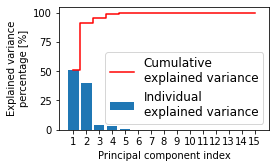

In [8]:
exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

fig, ax = plt.subplots(figsize=[4, 2.5])
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 12
ax.bar(range(1, len(exp_var) + 1), exp_var, align='center',
        label='Individual\nexplained variance')
ax.step(range(1, len(exp_var) + 1), cum_exp_var, where='mid',
         label='Cumulative\nexplained variance', color='red')

ax.set_ylabel('Explained variance\npercentage [%]')
ax.set_xlabel('Principal component index')
ax.set_xticks(ticks=range(1, len(exp_var) + 1))
ax.legend(loc='best', fontsize=12)
fig.tight_layout()
fig.savefig(save_figures + 'PCA_exp_vars.pdf', dpi=300, bbox_inches='tight')
fig.savefig(save_figures + 'PCA_exp_vars.png', dpi=300, bbox_inches='tight')

In [9]:
components = pd.read_csv(save_figures + 'PCA_components.tsv', sep='\t', index_col=0)

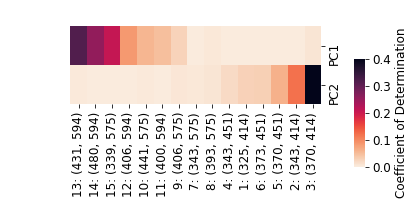

In [10]:
# wl_index = [
#     '(343, 575)', '(343, 451)', '(373, 451)','(370, 414)',  '(343, 414)', '(370, 451)', '(325, 414)','(393, 575)',  
#     '(431, 594)', '(480, 594)', '(339, 575)', '(406, 594)', '(441, 575)', '(400, 594)', '(406, 575)', # PC1
#             ]
df = pow(components.loc[['PC1', 'PC2']], 2).T.clip(0, 0.4)
idx = df[8:].sort_values('PC1', ascending=False).index.tolist() + df[:8].sort_values('PC2').index.tolist()
wl_index = [i for i in idx]
df = df.loc[wl_index]
index = [['', ' '][list(components.columns).index(i) + 1 < 10] + str(list(components.columns).index(i) + 1) + ': ' + i 
         for i in wl_index]
df.index = index

rcParams['pdf.fonttype'] = 42
g = sns.clustermap(df.T, col_cluster=False, row_cluster=False,
                vmin=0, vmax=0.4, cbar_pos=[1, 0.2, 0.03, 0.5],
                cbar_kws={'label':'Coefficient of Determination'}, cmap='rocket_r',
                figsize=[5, 3])
# g.fig.text(0.1, 0.82, 'Coefficient of Determination')
g.savefig(save_figures + 'square_R2.pdf', dpi=150, bbox_inches='tight')

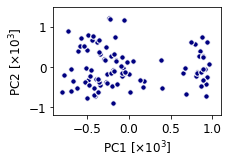

In [11]:
# plot a scatter plot with PC1 and PC2
fig, ax = plt.subplots(figsize=[3, 2])
rcParams['font.size'] = 12
ax.scatter(X_r[:, 0]/10e3, X_r[:, 1]/10e3, edgecolor='white', s=30, color='navy')
ax.set(xlabel='PC1 [×$10^3$]', ylabel='PC2 [×$10^3$]', #  [×$10^3$]
#        xticks=[-1. , -0.5,  0. ,  0.5,  1. ,  1.5], 
#        yticks=[-2., -1.,  0.,  1.,  2.,  3.],
       xlim=[-0.9, 1.1], ylim=[-1.2, 1.5]
      )

fig.savefig(save_figures + 'PC2_PC1.pdf', dpi=300, bbox_inches='tight')

## correlation between PC1, PC2 with gene expression

In [12]:
PCA_df = pd.read_csv(save_figures + 'PCA_15PC.tsv', sep='\t', index_col=0)

# compute the correlations between PC1, PC2 and gene expression
feas = ['PC1', 'PC2']
# add PC1 and PC2 to dataset
adata.obs['PC1'] = PCA_df[: -1].loc[adata.obs_names]['PC1']
adata.obs['PC2'] = PCA_df[: -1].loc[adata.obs_names]['PC2']

corr = get_correlation(adata, feas)
corr['Frac'] = 100 * (adata[:, corr.index].X > 0).sum(axis=0) / 95
corr['Number'] = (adata[:, corr.index].X > 0).sum(axis=0)
corr.to_csv(save_figures + 'correlation_PCA.tsv', sep='\t')

<ipython-input-3-73935c2876cc>:40: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


### genes filtered via coefficients of correlation

In [13]:
corr = pd.read_csv(save_figures + 'correlation_PCA.tsv', sep='\t', index_col=0)
df = corr.copy()

In [61]:
def ellipse_settings(df, PC1, PC2, threshold):
    # parameters of ellipse
    xr = df[PC1][df[PC1] > 0].quantile(1 - threshold)
    xl = df[PC1][df[PC1] < 0].quantile(threshold)
    x0 = (xr + xl) / 2 # x-position of the center

    yr = df[PC2][df[PC2] > 0].quantile(1 - threshold)
    yl = df[PC2][df[PC2] < 0].quantile(threshold)
    y0 = (yr + yl) / 2 # y-position of the center

    a = (abs(xr) + abs(xl))  # radius on the x-axis
    b = (abs(yr) + abs(yl))  # radius on the y-axis

    x, y = df[[PC1, PC2]].values.T
    theta = np.arctan(((x -x0) * (y - y0)).mean()/((x - x0) * (x - x0)).mean()) / np.pi * 180 # Ordinary least squares
    
    cos_angle = np.cos(np.radians(180. - theta))
    sin_angle = np.sin(np.radians(180. - theta))
    xc = x - x0
    yc = y - y0
    xct = xc * cos_angle - yc * sin_angle
    yct = xc * sin_angle + yc * cos_angle 
    rad_cc = (xct**2/(a/2)**2) + (yct**2/(b/2)**2) # rad_cc > 1 means outside of the ellipse
    out_ellipse_idx = np.where(rad_cc >= 1)[0]
    
    # PC1: 0.25 and PC2: 0.1 is self defined
    orange_idx = list(set(out_ellipse_idx) & 
                      set(np.where(df[PC1] >= 0.25)[0]) )
    navy_idx = list(set(out_ellipse_idx) & 
                    set(np.where(df[PC1] <= -0.25)[0]))
    purple_idx = list(set(out_ellipse_idx) & 
                      set(np.where((-0.1 > df[PC2]) & (-0.25 < df[PC1]) & (0.25 > df[PC1]))[0]))
    red_idx = list(set(out_ellipse_idx) & 
                   set(np.where((0.1 < df[PC2]) & (-0.25 < df[PC1]) & (0.25 > df[PC1]))[0]))
    
    df['ellipse'] = 'gray'
    df.loc[df.index[orange_idx], 'ellipse'] = 'orange'
    df.loc[df.index[navy_idx], 'ellipse'] = 'navy'
    df.loc[df.index[purple_idx], 'ellipse'] = 'purple'
    df.loc[df.index[red_idx], 'ellipse'] = 'red'
    
    return {'df': df, 'xy': (x0, y0), 'theta': theta, 'width': a, 'height': b}

def plot_ellipse2(df, xy, theta, width, height, PC1, PC2, alpha=0.32):
    # plot
    fig, ax = plt.subplots(figsize=[4, 2.5])
    from matplotlib.patches import Ellipse

    rgb = list(mpl.colors.to_rgba('grey'))[:-1]
    ellipse = Ellipse(xy=xy, angle=theta, width=width, height=height, edgecolor='k',
                      facecolor=tuple(rgb + [0.1]), ls='--', lw=0.5, zorder=0.5)
    ax.add_patch(ellipse)
    
    sns.scatterplot(data=df, x=PC1, y=PC2, hue='ellipse', 
                    palette=['gray', 'orange', 'navy', 'purple', 'red'], 
                    hue_order=['gray', 'orange', 'navy', 'purple', 'red'], alpha=alpha, ax=ax)

    sns.kdeplot(data=df, x=PC1, y=PC2, fill=False, cmap='rocket_r') #cmap='rocket_r'
    ax.set_xlim(-0.8, 0.8)
    ax.set_ylim(-0.5, 0.5)
    ax.axvline(0, color='gray', zorder=0.5, ls='--', lw=1)
    ax.axhline(0, color='gray', zorder=0.5, ls='--', lw=1)

    ax.set(xlabel=r'$\rho$ [{} vs gene exp]'.format(PC1), ylabel=r'$\rho$ [{} vs gene exp]'.format(PC2))
    ax.legend().remove()
    
    return {'fig': fig, 'ax': ax}

In [30]:
df = corr[corr['Number'] >= 10]
PC1, PC2 = 'PC1', 'PC2'
threshold = 0.01

ellipse_res = ellipse_settings(df, PC1, PC2, threshold)
df_ellipse, xy, theta, width, height = ellipse_res['df'], ellipse_res['xy'], ellipse_res['theta'], ellipse_res['width'], ellipse_res['height']

<ipython-input-18-8d41509e0a9b>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ellipse'] = 'gray'


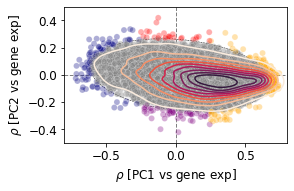

In [43]:
fig = plot_ellipse2(df_ellipse, xy, theta, width, height, PC1, PC2)['fig']
fig.savefig(save_figures + 'scatter_PC12.pdf', dpi=150, bbox_inches='tight')
fig.savefig(save_figures + 'scatter_PC12.png', dpi=150, bbox_inches='tight')

In [35]:
ellipse_genes = {}

for key in ['orange', 'navy', 'purple', 'red']:
    ellipse_genes[key] = df[df['ellipse'] == key].index.tolist()

In [36]:
import gseapy as gp

def pathway_df(gene_list):    
    pthw = gp.enrichr(gene_list=gene_list,
                         gene_sets=['GO_Biological_Process_2021'],
                         description='pathway',
                         cutoff = False).res2d

    pthw_plot = pthw[:10]
    pthw_plot['-log10(P-value)'] = -np.log10(pthw_plot['P-value'])
    
    return pthw_plot

In [37]:
ellipse_show = {}
for key in ['orange', 'navy', 'purple', 'red']:
    ellipse_show[key] = pathway_df(ellipse_genes[key])

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2023-05-16 11:31:06,509 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = False
<ipython-input-36-42ec577ea9ae>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pthw_plot['-log10(P-value)'] = -np.log10(pthw_plot['P-value'])
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.resul

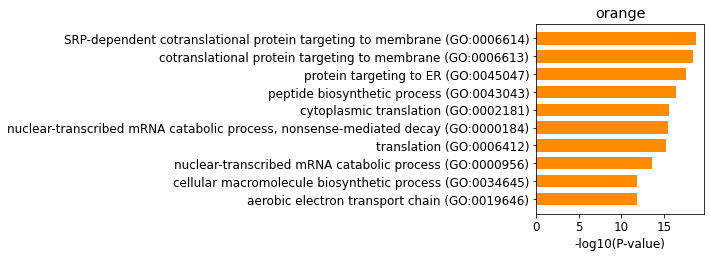

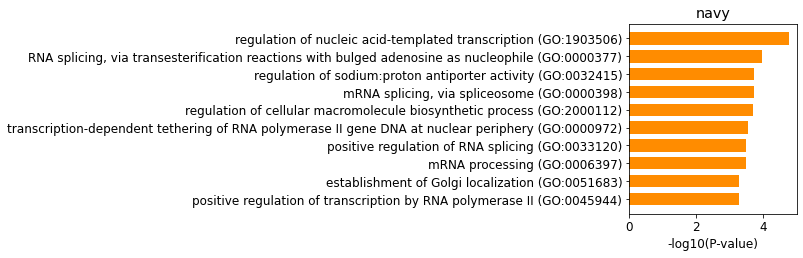

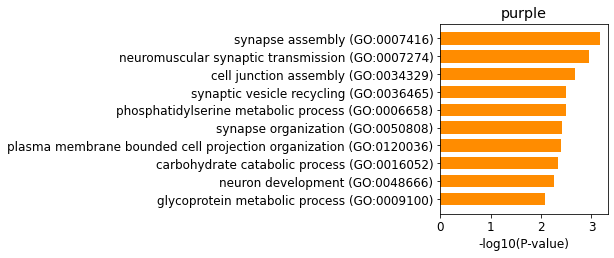

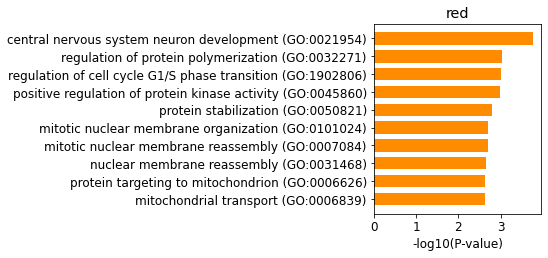

In [45]:
threshold = 0.01
gene_n = 10
for key in ['orange', 'navy', 'purple', 'red']:
    
    fig, ax = plt.subplots(figsize=[3, 3.5])
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 12

    ax.barh(range(10), ellipse_show[key]['-log10(P-value)'][::-1], height=0.7, color='darkorange')
    ax.set_yticks(range(10))
    ax.set_yticklabels(ellipse_show[key]['Term'][::-1])
    ax.set_title(key)

    ax.set_xlabel('-log10(P-value)')
    fig.savefig(save_figures + 'ellipse_gene_{}_quartile_{}_{}.pdf'.format(gene_n, threshold, key), 
                dpi=150, bbox_inches='tight')

In [24]:
# PPP3CA: ATPase binding activity
# KYNU: involved in the biosynthesis of NAD cofactors from tryptophan through the kynurenine pathway

# POLR2A: This gene encodes the largest subunit of RNA polymerase II

# DSCAM, ABHD12: nervous system

# NAPA: Required for vesicular transport between the endoplasmic reticulum and the Golgi apparatus (Probable)

df[df['ellipse'] == 'purple'].sort_values(['PC2'])

,PC1,PC2,Frac,Number,ellipse
gene_name,,,,,
CEP78,0.019233,-0.421996,33.684211,32,purple
EEF2K,-0.108627,-0.399692,28.421053,27,purple
RCAN3,0.244082,-0.363874,12.631579,12,purple
FBXL16,0.121819,-0.340846,10.526316,10,purple
FAM21A,0.107104,-0.335762,43.157895,41,purple
COBL,0.052594,-0.323015,13.684211,13,purple
DSCAM,-0.078936,-0.321152,55.789474,53,purple
ERC2,-0.172593,-0.320343,32.631579,31,purple
REV3L,0.015115,-0.319336,52.631579,50,purple


In [118]:
# save as a supplementary table

a = df[df['ellipse'] != 'gray']
a.rename(columns={'ellipse': 'Group', 
                  'Frac': 'Cell_exp_frac',
                  'Number': 'Cell_exp_frac',
                  'PC1': 'ρ[PC1_vs_Exp]',
                  'PC2': 'ρ[PC2_vs_Exp]',
                 }).to_csv('/home/yike/phd/cancer_cells_img_seq/docs/hyperspectral_sequencing_ewa/tables/ML_sig_genes.tsv', sep='\t')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

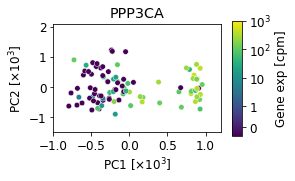

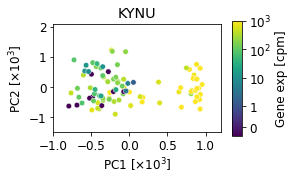

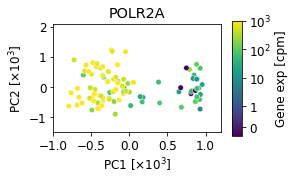

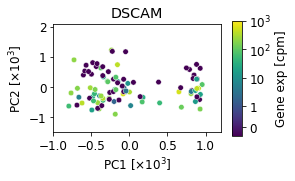

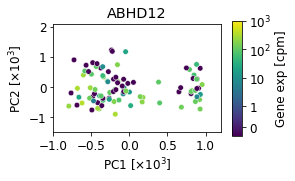

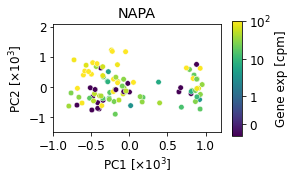

In [27]:
PCA_df = pd.read_csv(save_figures + 'PCA_15PC.tsv', sep='\t', index_col=0)

for gene in ['PPP3CA', 'KYNU', 'POLR2A', 'DSCAM', 'ABHD12', 'NAPA']:
    PCA_plot(PCA_df, adata, gene, save_figures +'/paper/', filetype='.pdf')